### Часть 1:

-----

Разберем классические (ненагруженные) представления.

####  word2vec, doc2vec и fasttext

1. word2vec – векторное представление слова
2. как сделать вектор документа?
    * усреднить все вектора слов
    * усреднить все вектора слов с $tf-idf$ весами
    * doc2vec
3. fasttext – векторное представление $n$-грам


Загрузим библиотеки с которыми будем работать:

In [44]:
import numpy as np
import pandas as pd
import random
from pymystem3 import Mystem
import re
from sklearn.metrics import *
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

Загрузим статьи с которыми будем работать сегодня и реализуем минимальный препроцессинг:

In [45]:
m = Mystem()
regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""


def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()
    except:
        return " "

In [46]:
df_neg = pd.read_csv("./../data/sentiment_msgs/negative.csv", sep=';', header = None, usecols = [3])
df_pos = pd.read_csv("./../data/sentiment_msgs/positive.csv", sep=';', header = None, usecols = [3])

In [47]:
df_neg['sent'] = 'neg'
df_pos['sent'] = 'pos'

In [48]:
df = pd.concat([df_neg, df_pos])
df.columns = ['text', 'sent']

In [49]:
df.text = df.text.apply(words_only)

In [50]:
df.text = df.text.apply(lemmatize)

In [51]:
df.head()

,text,sent
0,на работа быть полный пиддеса :| и так каждый ...,neg
1,коллега сидеть рубиться в Urban terror а я из ...,neg
2,elina_ post как говорить обещаной три год ждат...,neg
3,желать хороший пол тот и удачный посадка я быт...,neg
4,обновлять за какой то леший surf теперь не раб...,neg


In [52]:
texts = [df.text.iloc[i].split() for i in range(len(df))]

# Модель [word2vec](https://towardsdatascience.com/word2vec-research-paper-explained-205cb7eecc30)
----

Word2Vec - **это модель**, которая используется для представления слов в виде векторов. Этот метод позволяет нам вычислить семантическую близость между словами. 

Подохды к работе через word2vec:
1. _**Архитектурный:**_ Word2Vec предлагает 2 основные архитектуры: CBOW (Continuous Bag of Words) и Skip-Gram.
   - CBOW - пытается предсказать текущее слово, исходя из контекста окружающих его слов.
   - Skip-Gram - работает в другом направлении - пытается предсказать контекстные слова, исходя из текущего слова.
2. _**Обучение:**_ в основе word2vec лежит идя того, что значение слова может быть представлено посредством слов, которые часто встречаются рядом с ним. Модель обучается только на больших корпусах текстовых данных. На маленьких корпусах обучать модель не имеет никакого практического ни логического смысла. 
3. _**Контекстно окно.**_ При обычении модели word2vec выбирается определенное контекстное окно. Например, если окно равно 5 токенам, то это означает, что будут учитываться 2 слова перед текущим токеном и 2 слова после него.
4. _**Размерность вектора**_. Векторное представление слова может иметь разную размерность. Часто используемые значения - 100, ..., 800. Выбор размерности зависит от объема данных корпуса и конкретной задачи. Более высокая размерность может улучшить качество, но увеличит время обучения и объем потребляемых ресурсов.

# Общая идея

Почти тоже самое что и Embedding, который мы с вами видели, за исключением пары состовляющих. Алгоритм и подход Word2Vec работает с большим текстовым корпусом и согласно определенным правилам, которые будут рассмотренны, присваивает каждому слову уникальный набор чисел (тот же вектор). **Такой уникальный набор чисел для слова называется *семанитическим вектором* .**


Ключевая идея семантических векторов - дистрибутивная гипотеза, смысл которой состоит в том, что смысл слова заключается не в наборе его букв или его представлении, а в том, какими словами окруженно наше слово (слева, справа). То есть смысловая нагрузка слова распределена между элементами его возможных контекстов. Это и есть дистрибутивная гипотеза.



## Семантические вектора :

Представим себе квадратную матричку (таблицу) в которой каждая *строка* - это какое-то слово из нашего словаря, который был построен из корпуса наших документов. Они идут по порядку (допустим от А до Я). *Столбцы* - это теже самые слова и они также расположены по порядку (А-Я). В ячейке на пересечении столбца и строки записывается сколько раз, сколько слово из строки встретилось в корпусе рядом со словом из столбца (дальше пойдут вероятности):

![img](./../src/imgs/semantic_vectors.png)

Алгоритм (-ы) word2vec используют семантические вектора и контекст, чтобы сформировать численные представления слов, которые позволяют отображать семантически сходные слова в близкие друг другу вектора в некотором пространстве. Как определяется семантическая схожесть в таких веткорах - метрикой близости. Word2Vec основан на обучении простой нейронной сети.

## [Математический подход:](https://arxiv.org/pdf/1301.3781.pdf)
----

По слову $w$ предсказываем слово $w'$
![img](./../src/imgs/w2v_1.png)

$X$ – one-hot представление входного слова $w$

$y_i =  p(w' = w_i)$

$W = |V \times N | $ – матрица весов между входным и скрытым слоем

$h =x^T W$ – скрытый слой – выбирает одну строку из матрицы $W_{}$

$W' = |N \times V| $ – матрица весов между скрытым слоем и выходеым

$u_j = W' h$  – выходной слой

$p(w_j) = y_j = \frac{exp(u_j)}{\sum_i exp(u_i)} $ – искомая вероятность



## Continious bag of word

![img](./../src/imgs/w2v_2.png)


## Skip-gram- по слову предсказываем его контекст

![img](./../src/imgs/w2v_3.png)

Как можно обучить word2vec, так как это нейросетевой подход, то можно просто воссоздать архитектуру, указанную выше и обучиться на большом корпусе документов, сформировав свой словарь.

Рассмотрим псевдокод:
----
#### 1. Вариант в лоб:

```
import torch

class Word2Vec(torch.nn.Module):
    def __init__(self, vocabulary_size, embedding_dimension):
        self.u = torch.nn.Embedding(vocabulary_size, embedding_dimension)
        self.v = torch.nn.Embedding(vocabulary_size, embedding_dimension)

    def forward(self, word, context):
        for context_word in context:
            loss = - self.u(word).T.dot(self.v(context_word))
            cummulative_softmax = 0
            for i in range(vocabulary_size):
                if i == context_word:
                    continue
                cummulative_softmax += self.u(word).T.dot(self.v(context_word)).exp()
            loss += torch.log(cummulative_softmax)
            loss.backward()
     ...
```

#### 2. Вариант построить одну из архитектур выше:

```
import torch

class Word2Vec(toch.nn.Module):
    def __init__(self, vocabulary_size, embedding_dimension):
        self.u = torch.nn.Embedding(vocabulary_size, embedding_dimension)
        self.v = torch.nn.Linear(embedding_dimension, vocabulary_size, bias=False)

     def forward(self, x):
        return self.v(self.u(x))

word_to_vec = Word2Vec(...)

def train():
    criterion = torch.nn.CrossEntropyLoss()
    ....
```

#### 3. Использовать уже предобученные эмбеддинги, которые доступны по сслыкам [Word2Vec](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit) И [GloVe](https://nlp.stanford.edu/projects/glove/).

Ссылка на визуализации Jay Alamar, [Word2Vec](https://jalammar.github.io/illustrated-word2vec)

In [53]:
import numpy as np
from annoy import AnnoyIndex

class PretrainedEmbeddings(object):
    def __init__(self, word_to_index, word_vectors):
        """
        Parameters
        ----------
        word_to_index (dict): словарь отображения слов в целочисленные индексы
        word_vectors (numpy ndarray): массив Numpy
        """
        self.word_to_index = word_to_index
        self.word_vectors = word_vectors
        self.index_to_word = {v: k for k, v in self.word_to_index.items()}
        self.index = AnnoyIndex(len(word_vectors[0]), metric='euclidean') # можно поменять на метрику хемминга, левенштейна и прочее
        for _, i in self.word_to_index.items():
            self.index.add_item(i, self.word_vectors[i])
        self.index.build(50)

    @classmethod
    def from_embeddings_file(cls, embedding_file):
        """
        Создание экземпляра на основании файла предобученных векторов.

        Обычно файл предобученных вектором матрица вида:

        word_0  x_11   x_12   x_13    ...  x_nm
        word_1  x_21   x_22   x_23    ...  x_nm
        ...... ...... ...... ...... ...... ......
        word_n  x_3m   x_3m   x_3m    ...  x_nm

        Parameters
        ----------
        embedding_file (str: Path format): директория расположения файла эмбеддингов
        Returns
        -------
        Экземпляр PretrainedEmbeddings
        """
        word_to_index = {}
        word_vectors = {}
        with open(embedding_file, encoding="utf-8") as file:
            for line in file.readlines():
                line = line.split(" ")
                word = line[0]
                vector = np.array([float(x) for x in line[1:]])
                word_to_index[word] = len(word_to_index)
                word_vectors.append(vector)
        return cls(word_to_index, word_vectors)

    def get_embedding(self, word):
        return self.word_vectors[self.word_to_index[word]]

    def get_closest_vector(self, vector, n=1):
        """
        Возвращаем ближайших соседей указанного вектора (vector)
        Parameters
        vector np.ndarray: размер должен соответствовать размеру векторов в индексе
        n int : количество соседей
        ----------
        Returns
        list [str, ..., str]: ближайшие соседи
        ------
        """
        nn_indices = self.index.get_nns_by_vector(vector, n)
        return [self.index_to_word[i] for i in nn_indices]

    def compute_semantic_vectors(self, word1, word2, word3):
        """
        Считает семантическое сходство между заданными словами. Можно переделать под *args чтобы метод не зависел от количества
        поданных слов.
        """
        vector_one = self.get_embedding(word1)
        vector_two = self.get_embedding(word2)
        vector_three =self.get_embedding(word3)

        spatial_relationship = vector_two - vector_one
        vector_four = vector_three + spatial_relationship
        closest_words = self.get_closest_vector(vector_four, n=4)
        existing_words = set([word1, word2, word3])
        closest_words = [word for word in closest_words if word not in existing_words]

        if len(closest_words)  == 0:
            print("No vectors for the existing one.")
            return None
        for word4 in closest_words:
            print("{} : {} :: {} : {}".format(word1, word2, word3, word4))

#### 4. Можно воспользоваться библиотеками для NLP, например gensim:

In [54]:
%%time
from gensim.models import Word2Vec # Используется SkipNgram подход (SGNS) когда по слову вне зависимости от положения предсказываем его контексты

word_to_vec = Word2Vec(texts, vector_size=100, window=5, min_count=5, workers=-1)
# vector_size - размерность эмбеддинга которую мы хотим получить ("длина вектора")
# window - размер окна (на сколько N-gram будет порезана последовательность)
# min_count - слова которые встречаются реже чем min_count не обучаются в модели

word_to_vec.save('./word2vec.pk')

CPU times: total: 766 ms
Wall time: 786 ms


Теперь обученное представление мы можем просто воспользоваться сохраненным представлением (Embedding'Ом):

In [55]:
from gensim.models import Word2Vec
word_to_vec = Word2Vec.load('./word2vec.pk')

In [58]:
# Можно делать поиск по похожим (ближайшим) векторам слов
word_to_vec.wv.most_similar("возможно")

[('музыка', 0.36244937777519226),
 (':|', 0.30914145708084106),
 ('обнимать', 0.30560556054115295),
 ('разрешать', 0.30209603905677795),
 ('лекция', 0.29588747024536133),
 ('задумываться', 0.2873219847679138),
 ('отсюда', 0.2845868468284607),
 ('похудеть', 0.26789575815200806),
 ('реклама', 0.2607080340385437),
 ('дача', 0.25817587971687317)]

In [61]:
# Можно решать задачи на аналогии positive слова в пропорции со знаком + (то есть Хороший - хороший + плохой)
word_to_vec.wv.most_similar(positive=["рука","голова"], negative=["здесь"])

[('говориться', 0.32936596870422363),
 ('муж', 0.30755186080932617),
 ('вкладка', 0.2895914316177368),
 ('разговор', 0.2852182686328888),
 ('вторник', 0.2787803113460541),
 ('продолжать', 0.27640292048454285),
 ('пиздец', 0.2743000388145447),
 ('над', 0.2642248272895813),
 ('выздоравливать', 0.2627519369125366),
 (':(', 0.26057639718055725)]

In [62]:
# Поиск лишнего слово в последовательности (по попарным расстояниям)
word_to_vec.wv.doesnt_match("борщ сметана макароны пирожок консомэ кошка".split())

'кошка'

При помощи word2vec эмбеддинга мы можем построить визуализацию нашего пространства слов:

In [63]:
from nltk import FreqDist

top_words = []
fd = FreqDist()

for text in texts:
    fd.update(text)

for i in fd.most_common(1000):
    top_words.append(i[0])

print(top_words)

['я', 'не', 'и', 'в', ':(', 'что', 'на', 'а', 'RT', '(', 'быть', 'как', 'то', 'с', 'у', 'ты', 'так', 'http://t', 'это', 'но', 'хотеть', 'все', ':', 'он', 'за', 'по', 'ну', 'уже', 'мой', 'этот', 'весь', 'же', 'мочь', 'такой', 'вот', 'мы', 'только', '((', 'день', 'еще', 'сегодня', 'из', 'когда', 'нет', 'к', 'они', 'бы', 'кто', 'очень', 'да', 'один', '(((', 'теперь', 'она', 'завтра', 'какой', 'от', 'даже', 'блин', 'почему', 'вы', 'надо', 'просто', 'знать', 'до', 'человек', 'свой', 'вообще', 'делать', 'вс', 'спать', 'себя', 'там', '=(', 'сейчас', 'тоже', 'если', 'без', 'понимать', 'опять', 'раз', 'любить', 'тот', 'много', 'который', 'о', 'год', 'время', 'сказать', 'ничто', 'думать', 'час', 'для', 'сидеть', 'хорошо', 'болеть', 'пойти', 'самый', 'о_о', 'утро', 'ни', 'идти', 'новый', 'со', 'работа', 'говорить', 'хотеться', 'жизнь', 'после', 'про', 'тут', 'школа', 'co/', 'жаль', 'никто', 'сделать', 'неделя', 'скоро', 'т', 'давать', 'плохо', 'мама', 'потом', 'становиться', '!', 'смотреть', ':((

In [64]:
top_words_vec = word_to_vec.wv[top_words]

In [65]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

In [66]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook


output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)



Loading BokehJS ...

In [70]:
show(p)

### Кластеризация слов

In [67]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(top_words_vec)

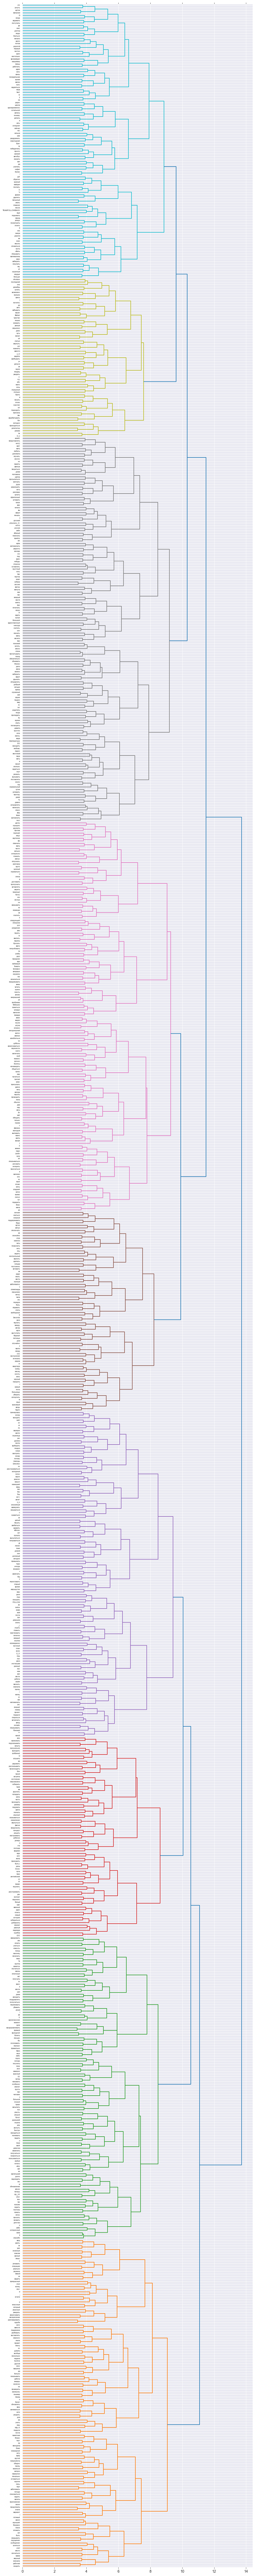

In [68]:
from scipy.cluster.hierarchy import  ward, dendrogram

linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(10, 100))
ax = dendrogram(linkage_matrix, orientation="right", labels=top_words);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout()

plt.savefig('w2v_clusters.png', dpi=200) #save figure as ward_clusters

## Классификация текстов

Кроме того мы можем использовать все указанные подходы связанные с word2vec для классификации текста. Например те признаки (Вектора, похожие веткора и прочее) могут быть использованы в качестве меток класса для задачи классификации текста:

In [71]:
X = df.text.tolist()
y = df.sent.tolist()

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)

print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

total train examples 151978
total test examples 74856


In [72]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.popitem()[1])
        # self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [73]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(w2v.popitem()[1])
        # self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [74]:
w2v = dict(zip(word_to_vec.wv.index_to_key, word_to_vec.wv.vectors))

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

rfc_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
                    ("extra trees", RandomForestClassifier(n_estimators=20))])

rfc_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
                          ("extra trees", RandomForestClassifier(n_estimators=20))])

In [76]:
rfc_w2v.fit(X_train,y_train)
pred = rfc_w2v.predict(X_test)

Precision:   0.76
Recall:   0.54
F1-measure:   0.42
Accuracy:   0.55
              precision    recall  f1-score   support

         neg       1.00      0.08      0.15     36849
         pos       0.53      1.00      0.69     38007

    accuracy                           0.55     74856
   macro avg       0.76      0.54      0.42     74856
weighted avg       0.76      0.55      0.43     74856


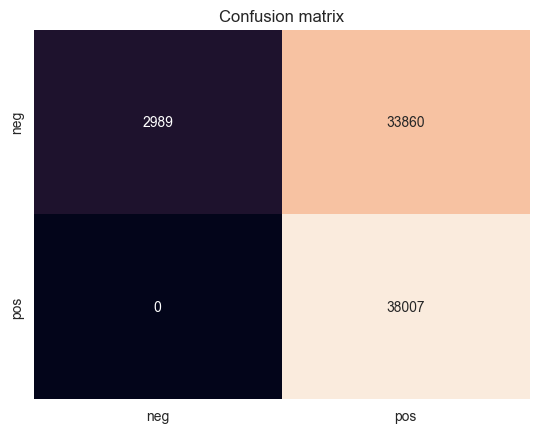

In [77]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))

print(classification_report(y_test, pred))

labels = rfc_w2v.classes_

sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [78]:
rfc_w2v_tfidf.fit(X_train,y_train)
pred = rfc_w2v_tfidf.predict(X_test)

Precision:   0.76
Recall:   0.54
F1-measure:   0.42
Accuracy:   0.55
              precision    recall  f1-score   support

         neg       1.00      0.08      0.15     36849
         pos       0.53      1.00      0.69     38007

    accuracy                           0.55     74856
   macro avg       0.76      0.54      0.42     74856
weighted avg       0.76      0.55      0.43     74856


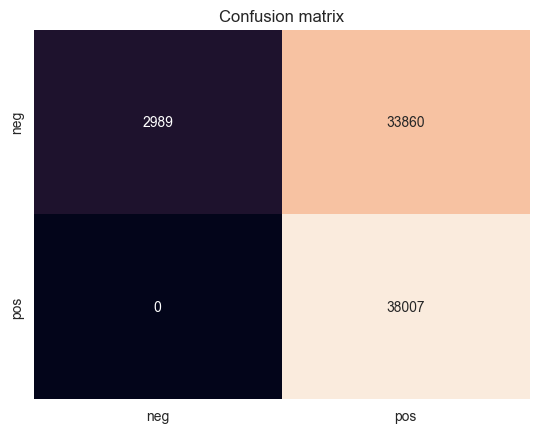

In [79]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))

print(classification_report(y_test, pred))

labels = rfc_w2v.classes_

sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Продвинутые особенности модели:

* Subsampling Frequent Words - часто встречающиеся слова (например союзы, предлоги и т.д.) могут добавлять меньше семантической ценнсои, поэтому их можно случайно уменьшить во время обучения. Это ускоряет процесс обучения и улучшает качество векторов для редких слов. 
* Negative Sampling - вместо обучения на всех словах в словаре, на каждой итерации выбирается небольшой набор отрицательных образцов (слов, которые не являеются текущим контекстом). Это ускоряет обучение. 



Где используется:

1. Аналогии: благодаря векторному представлению слов можно находить слова по аналогии.  Например, "король" - "мужчина" + "женщина" может дать "королева".
2. Кластеризация слов: схожие слова можно группировать в кластеры.
3. Рекомендации: например, для рекомендации следующего слова в последовательности.
4. Семантический поиск: Векторы слов позволяют вычислять семантическую близость между документами или абзацами текста.
5. Классификация текста: Векторные представления слов могут служить основой для признаков в моделях классификации, например, для определения тональности отзыва.



Сравнение с другими подходами:

1. FastText: Разработан Facebook, этот метод похож на Word2Vec, но он учитывает символьные n-грамы в словах. Это позволяет ему эффективно работать с морфологически богатыми языками и правильно обрабатывать словоформы, которых нет в обучающем датасете.
2. GloVe (Global Vectors for Word Representation): Этот метод разработан в Stanford и основан на статистике совместной встречаемости слов. В отличие от Word2Vec, который обучается на локальных контекстах слов, GloVe работает с глобальной статистикой.
3. BERT (Bidirectional Encoder Representations from Transformers): Это многослойная модель, которая использует механизм внимания (attention mechanism) для кодирования контекста слова с учетом информации как слева, так и справа от него. BERT позволяет достичь значительных успехов в многих задачах обработки естественного языка.


Проблемы и ограничения модели Word2Vec:

* Статичные представления: Word2Vec предоставляет один и тот же вектор для слова, независимо от его контекста. Это означает, что у многозначных слов будет только одно векторное представление. Модели, основанные на механизме внимания, такие как BERT, пытаются решить эту проблему.
* Необходимость больших данных: Для обучения качественной модели Word2Vec требуются большие объемы текстовых данных.


Альтернативы:

* Embeddings from Language Models (ELMo): Представляет собой метод генерации векторных представлений слов с учетом их контекста, что позволяет получить разные векторы для одного и того же слова в разных контекстах.
* Transformers: Это архитектура, которая лежит в основе многих современных моделей NLP, включая BERT. Она использует механизмы внимания для кодирования информации о порядке слов и их контексте.

# Модели paragraph2vec aka doc2vec


word2vec с дополнительной меткой id документа

![img](./../src/imgs/w2v_4.png)


Немного улучшенная версия word2vec. Если выше мы занимались построением векторов для слов или одного слова, а потом усредняли вектора чтобы получить "вектор документа", то doc2vec реализован для того, чтобы мы могли для какого-то документа сделать свой вектоор преддставления.
Помимо слов и контекста, у нас теперь есть id документа, который добавляетсяся ко всем контекстам каждого слова и когда обучаем всю архитектуру обучаем еще вектор для порядкового номера.

In [80]:
from gensim.models.doc2vec import *

In [81]:
splitted_texts = [text.split() for text in X]
idx = [str(i) for i in range(len(X))]

docs = []
# Чтобы модель поняла отношения документов по Id нам надо пронумеровать эти документы, это делается следующим образом:
for i in range(len(X)):
    docs.append(TaggedDocument(splitted_texts[i], [idx[i]]))


model = Doc2Vec(vector_size=300, window=5, min_count=5, workers=8, alpha=0.025, min_alpha=0.01, dm=0)
# плюс в начале теперь нам надо построить словарь id докумеентов
model.build_vocab(docs)

# docvec1 = model.docvecs[0]
# docvecsyn1 = model.docvecs.doctag_syn0[0]
# docsim1 = model.docvecs.most_similar(id1)

model.train(docs, total_examples=len(docs), epochs=20)

In [82]:
class Doc2VecVectorizer(object):
    def __init__(self, d2v_model):
        self.d2v_model = d2v_model

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([self.d2v_model.infer_vector(text.split()) for text in X])


rfc_d2v = Pipeline([
    ("word2vec vectorizer", Doc2VecVectorizer(model)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])

rfc_d2v.fit(X_train,y_train)
pred = rfc_d2v.predict(X_test)

Precision:   0.52
Recall:   0.52
F1-measure:   0.52
Accuracy:   0.52
              precision    recall  f1-score   support

         neg       0.51      0.53      0.52     36849
         pos       0.53      0.50      0.51     38007

    accuracy                           0.52     74856
   macro avg       0.52      0.52      0.52     74856
weighted avg       0.52      0.52      0.52     74856


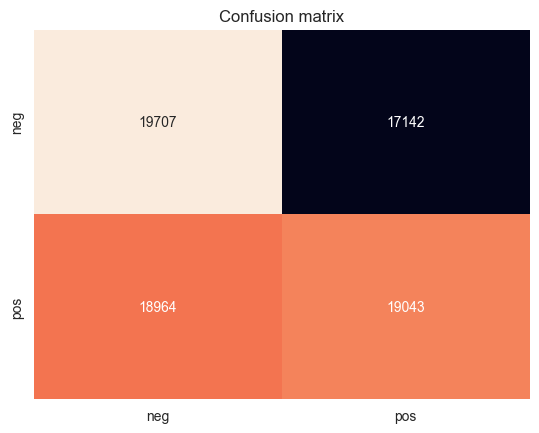

In [83]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

## [fasttext](https://amitness.com/2020/06/fasttext-embeddings/)

Слово $w$ представляем символьными $n$-грамами:

$n=3$, $G_{where} = \_wh, whe, her, re\_, \_where\_$

$sim_{w2v}(u,v) = <u,v>$


$sim_{ft}(u,v) = \sum_{e \in G_u} \sum_{g \in G_v} <e,v>$


<a href="https://github.com/facebookresearch/fasttext">Git Repository</a>
<a href="https://medium.com/@oleg.tarasov/building-fasttext-python-wrapper-from-source-under-windows-68e693a68cbb">Medium Story Guide</a>

```
git clone https://github.com/facebookresearch/fastText.git
cd fastText
pip install .
```


В word2vec существует проблема со словами которые модель не видела до этого, ваше представление просто не будет знать незнакомый вектор. Fasttext подход решил эту задачу при помощи перехода к символьным N-gram'ам, архитектура осталась такая же.
Будет выучивать свой вектор для каждой такой n-gram'ы. Затем когда будем находить близость между словами будем разбивать их на символьные n-Граммы. Если какогото слова в словаре нет, то с большей вероятностью какая-то n-gram Будет все равно присутствовать в тексте.


In [ ]:
import fasttext

with open('data.train.txt', 'w+') as outfile:
    for i in range(len(X_train)):
        outfile.write('__label__' + y_train[i] + ' '+ X_train[i] + '\n')

with open('test.txt', 'w+') as outfile:
    for i in range(len(X_test)):
        outfile.write('__label__' + y_test[i] + ' ' + X_test[i] + '\n')

In [ ]:
classifier = fasttext.supervised('data.train.txt', 'model')
result = classifier.test('test.txt')

print('P@1:', result.precision)
print('R@1:', result.recall)
print('Number of examples:', result.nexamples)

In [ ]:
pred = classifier.predict(X_test)


print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))

print(classification_report(y_test, [i[0] for i in pred]))
labels = rfc_w2v.classes_

sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

# Часть 2:

# Word Mover's Distance
## J. Kusner "From Word Embeddings to Document Distances"

![img](https://raw.githubusercontent.com/mkusner/wmd/master/fig1.png)

Существует еще одно использование word2vec в задаче paraphrase - подобрать похожие слова, чтобы выразить одну и туже мысль (помним про abstractive extraction в задаче summarization это один из способов решения такой задачки). Такой подход на равне с трансформерами используется в call-центрах, диалоговых системах, speech2text подходе.

Мы знаем что пространство эмбедингов обладают множеством полезных свойств, в том числе свойством, которое помогает нам искать семантически похожие слова (вектора).

Техническая проблема - порядок слов в предложении. Нам нужно определить какое слово из оригинального предложения мы можем отобразить в какое-нибудь слово в целевом предложении. Необходимо построить попарное сопоставление между словами. Один из методов решение задачи комивояджера (транспортной задачи), которая решается при помощи графавых вычислений.

Сделаем некую матрицу, по строчкам - слова из исходного предложения, по столбцам из другого. Посчитаем метрику между токенами и получим матрицу расстояний. Оптимизируем задачу на минимизацию расстояний между токенами. Затем после оптимизации выберем ближайшие токены и это будет перефразирование.

Формулировка задачи определения сходства между двумя предложениями как задачи транспортной задачи:

1. Пусть $X \in \mathbb{R}^{d \times n}$ – матрица эмбеддингов,  $d$ – размерность эмбеддинга, $n$ - количество слов;
2. Вектор-документ в векторной модели: $d \in \mathbb{R}^n$ состоит из $c_i = \texttt{count}(word_i, doc)$
3. Нормированный вектор-документ: $d_i = \frac{c_i}{\sum_i c_i}$
4. Расстояние между словами: $\texttt{cost}(word_i, word_j) = ||x_i - x_j||_2$

Дано два документа, $d, d'$. Пусть  $T \in \mathbb{R}^{n \times n}$, $T_{ij} \ge 0$ – матрица потока показывает расстояния от каждого слова $d$ до $d'$.

Транспортная задача:

$\min_{T \ge 0} \sum_{i,j}^n T_{ij}\texttt{cost}(word_i, word_j) $

при условии:

$\sum_{j} T_{ij} = d_i$

$\sum_{i} T_{ij} = d'_j$.

Задача решается средствами линейного программирования.

Используем fasttext эмбеддинги Facebook:

In [84]:
# Загружаем вектора отсюда https://fasttext.cc/docs/en/pretrained-vectors.html  в text формате на выходе получите файлик <name>.vec весит все 5 гб
model = KeyedVectors.load_word2vec_format('./../data/embeddings/wiki.ru.vec', binary=False)

In [86]:
# pip install pot
s1 = 'Ученые обнаружили ископаемую ящерицу с парой теменных глаз'
s2 = 'У палеогеновой ящерицы нашли вторую пару глаз'
s3 = 'Apple через два года откажется от процессоров Intel'

distance = model.wmdistance(s1, s2)
print ('distance between s1 and s2 = %.4f' % distance)

distance = model.wmdistance(s1, s3)
print ('distance between s1 and s3 = %.4f' % distance)

distance = model.wmdistance(s2, s3)
print ('distance between s2 and s3 = %.4f' % distance)

distance between s1 and s2 = 0.3252
distance between s1 and s3 = 0.5703
distance between s2 and s3 = 0.5574


Вычисляем попарное сходство между тремя тестовыми предложениями с использованием нормированных эмбеддингов:

In [87]:
model.init_sims(replace=True)

distance = model.wmdistance(s1, s2)
print ('distance between s1 and s2 = %.4f' % distance)

distance = model.wmdistance(s1, s3)
print ('distance between s1 and s3 = %.4f' % distance)

distance = model.wmdistance(s2, s3)
print ('distance between s2 and s3 = %.4f' % distance)

distance between s1 and s2 = 0.3252
distance between s1 and s3 = 0.5703
distance between s2 and s3 = 0.5574


Повторим тоже самое на корпусе твиттов
Считываем данные:

In [88]:
import pandas as pd
data = pd.read_csv('./../data/sentiment_msgs/positive.csv', sep=';', header=None,  index_col = False,
                  names = [ 'id', 'tdate', 'tuser', 'ttext', 'ttype',
                          'trep', 'tfav', 'tstcount', 'tfol','tfriend', 'listcount'])
data.head()

,id,tdate,tuser,ttext,ttype,trep,tfav,tstcount,tfol,tfriend,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23


Предобработка (приводим к нижнему регистру, удаляем стоп-слова и некириллические символы):

In [89]:
import re
regex = re.compile("[А-Яа-яё]+")

from nltk.corpus import stopwords

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))



def  remove_stopwords(text, stopwords = stopwords.words('russian')):
    try:
        return " ".join([token for token in text.split() if not token in stopwords])
    except:
        return ""


raw_tweets = data.ttext.tolist()
data.ttext = data.ttext.str.lower()
data.ttext = data.ttext.apply(words_only)
data.ttext = data.ttext.apply(remove_stopwords)


tweets = [tweet.split() for tweet in data.ttext.tolist()]

Инициализируем класс для вычисления близостей:

In [90]:
from gensim.similarities import WmdSimilarity
num_best = 10
instance = WmdSimilarity(tweets, model, num_best=10)

Задаем документ-запрос и предобрабатываем его:

In [91]:
s1 = 'Ученые обнаружили ископаемую ящерицу с парой теменных глаз'
query = words_only(s1).lower().split()

Поиск по запросу:

In [92]:
sims = instance[query]

И результаты:

In [93]:
print('Query:', query)
for i in range(10):
    print(sims[i][0])
    print(raw_tweets[sims[i][0]])
    print()

Query: ['ученые', 'обнаружили', 'ископаемую', 'ящерицу', 'с', 'парой', 'теменных', 'глаз']
2401
Ученые установили, что если пищу пережевывать, то давятся витамины, а если не пережевывать - люди.))

12140
@__cherry__bomb_ про девушку у которой врачи обнаружили рак .ну вообще интересный )))

94458
RT @jofutypobaty: Ученые скрестили гиену с пнем и получили гиенологическое дерево)))

29935
Американские ученые выяснили - в недосыпании детей виноваты родители -  http://t.co/NJXMM5DYrA А-а, это так ржачно, надо поделиться )))

109592
@RimVell всеееее, выкололи тебе этот глаз и пролезли в мозг!)

46433
читали? http://t.co/kVaartO6bfПортал:Ниасилили/t.A.T.u )) не в бровь, а в глаз,как говориться) всю статью можно растащить на цитаты)

114425
RT @VITAMIN_PERM: Сначала глаз сломался ... Потом и мозг треснул )))
 http://t.co/V6p6udMSQ4

93210
@Vladiysss мандаринку приложи,говорят помогает)
Сразу глаз пройдёт

56187
@freiman @vodolady отлично,  завтра приду на работу с баклашкой со словами "ученые 

# Задача Извлечения информации

* Именованные сущности: LOC, ORG, PER, TIME, GPE,
* Отношения: _parent_(PER, PER), _worksIn_(PER, ORG), _locatedIn_(ORG, LOC)
* Факты: _bornIn_(PER, LOC, TIME), _newEmployee_(PER, ORG, occupation, TIME)
* События: _bornIn_("born", PER, LOC, TIME), _newEmployee_(new, PER, ORG, occupation, TIME)

# извлечение именованных сущностей, Named Entity Recognition (NER)
* общие идеи
* локальный классификатор: RandomForest
* классификаторы последовательностей: CRF, biLSTM-CRF, charLSTM-wordLSTM

## Разметка


|             | В    | Британии | недавно | скончался | ученый | Стивен | Хокинг | .     |
|-------------|------|----------|---------|-----------|--------|--------|--------|-------|
| POS         | PREP | PROPN    | ADV     | VERB      | NOUN   | PROPN  | PROPN  | PUNCT |
| IOB (NE)    | O    | B-LOC    | B-TIME  | O         | O      | B-PER  | I-PER  | O     |
| IOBES (NE)  | O    | S-LOC    | S-TIME  | O         | O      | B-PER  | E-PER  | O     |
| IOB (REL)   |  O   | B-LOC    | O       | O        |   O    |   B-PER     | I-PER        |    O  |
| IOB (REL)   |  O   | B-LOC    | O       | B-Trigger/Death  | O| B-PER        |    I-PER  |O  |

IOB format -> LOC (location), PER (person), ORG (organization) ... 

IOB format -> Inside outside beginiing

B- begining of the entity
I- consecutive token bolongs to the entity
O- tag indicates that token does not belong to any entity

## Задача классификации последовательности (Sequence Labelling)

* $ \mathbf{x} = x_1, x_2, \ldots, x_n$, $x_i \in V$, $V$ - словарь
* $ \mathbf{y} = y_1, y_2, \ldots, y_n$, $x_y \in L$, $L$ - метки
* ${(\mathbf{x}^{(1)}, \mathbf{y}^{(1)}), (\mathbf{x}^{(2)}, \mathbf{y}^{(2)}), \ldots, (\mathbf{x}^{(m)}, \mathbf{y}^{(m)})}$ - обучающие данные


Задача: обучить классификатор $\mathbf{x} \rightarrow \mathbf{y}$


### Локальные методы
Задача: определить класс данного токена $x_i$ или данной группы или $n$-грамы $x_{i:j}$ (или данной пары токенов ( $(x_i, x_j) \in R?$ )
* Правила и словари
* Любой алгоритм классификации (Random Forest, Naive Bayes, ConvNets)

### Глобальные методы
Задача: определить лучшую последовательность меток: $\arg \max_{Y} P(Y|X)$
* Правила и словари
* Марковские модели максимальной энтропии [Maximum entropy Markov model, MEMM]
* Условные случайные поля [Conditional random field, CRF]
* Рекуррентные нейронные сети
* Структурированный метод опорных векторов [SVM$^{struct}$]

### Признаки для слов
* Регистр слова, есть ли строчные, заглавные буквы, аббревиатуры
* Префикс и суффикс слова
* Входит ли слово в словарь (например, список городов, имен, фамилий и др.)
* Часть речи слова, разбор слова
* Лемма или псевдооснова (стем) слова
* Синтаксические зависимости слова
* Семантическая роль слова
* Все тоже самое для левого и правого контекста

### Признаки для групп или $n$-грам
* Удовлетворяет ли группа или $n$-грама морфологическому шаблону
* Есть ли в группе или $n$-граме специфическое слово?
* Входит ли группа или $n$-грама в каком-нибудь словарь?

### Оценки качества извлечения именованных сущностей
* macro-, macro-, precision, recall, f1-measure, accuracy
* оценка на уровне токенов / групп

### Проблемы
1. Многозначность
2. Вложенность
3. Кореференция

In [95]:
from itertools import chain
import pandas as pd
import numpy as np

import torch
import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer, classification_report
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, RandomizedSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# https://eli5.readthedocs.io/en/latest/overview.html
import eli5
# https://sklearn-crfsuite.readthedocs.io/en/latest/
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report

## Данные: kaggle (GMB корпус)

In [96]:
data = pd.read_csv("./../data/ner_tags/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [97]:
words = list(set(data["Word"].values))

In [98]:
n_words = len(words); n_words

35177

In [99]:
data["Tag"].value_counts()

Tag
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64

In [100]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.data[self.data["Sentence #"] == "Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s["Word"].values.tolist(), s["POS"].values.tolist(), s["Tag"].values.tolist()
        except:
            self.empty = True
            return None, None, None

In [101]:
getter = SentenceGetter(data)
sent, pos, tag = getter.get_next()
print(sent, pos, tag)

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.'] ['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'IN', 'NNP', 'CC', 'VB', 'DT', 'NN', 'IN', 'JJ', 'NNS', 'IN', 'DT', 'NN', '.'] ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


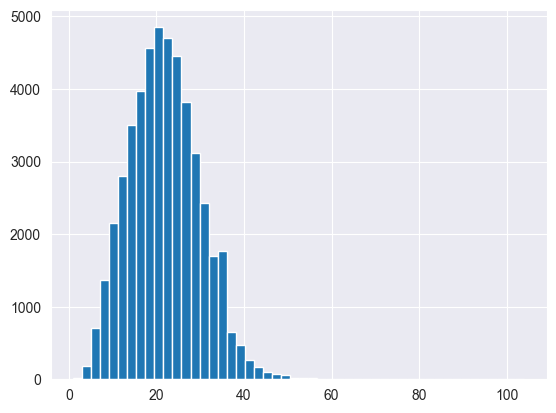

In [102]:
sentences = getter.sentences
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [103]:
class MemoryTagger(BaseEstimator, TransformerMixin):

    def fit(self, X, y):
        '''
        Expects a list of words as X and a list of tags as y.
        '''
        voc = {}
        self.tags = []
        for x, t in zip(X, y):
            if t not in self.tags:
                self.tags.append(t)
            if x in voc:
                if t in voc[x]:
                    voc[x][t] += 1
                else:
                    voc[x][t] = 1
            else:
                voc[x] = {t: 1}
        self.memory = {}
        for k, d in voc.items():
            self.memory[k] = max(d, key=d.get)

    def predict(self, X, y=None):
        '''
        Predict the the tag from memory. If word is unknown, predict 'O'.
        '''
        return [self.memory.get(x, 'O') for x in X]

#### Классификатор на правилах: ```MemoryTagger```
1. Запоминаем,сколько раз и каким тегом было помечено слово
2. Предсказываем самый частый тег
3. Не работает для несловарных слов

In [104]:
tagger = MemoryTagger()
tagger.fit(sent, tag)

In [105]:
print(sent)
print(tagger.predict(sent))

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [106]:
words = data["Word"].values.tolist()
tags = data["Tag"].values.tolist()
pred = cross_val_predict(estimator=MemoryTagger(), X=words, y=tags, cv=5)

In [107]:
report = classification_report(y_pred=pred, y_true=tags)
print(report)

              precision    recall  f1-score   support

       B-art       0.20      0.05      0.09       402
       B-eve       0.54      0.25      0.34       308
       B-geo       0.78      0.85      0.81     37644
       B-gpe       0.94      0.93      0.94     15870
       B-nat       0.42      0.28      0.33       201
       B-org       0.67      0.49      0.56     20143
       B-per       0.78      0.65      0.71     16990
       B-tim       0.87      0.77      0.82     20333
       I-art       0.04      0.01      0.01       297
       I-eve       0.39      0.12      0.18       253
       I-geo       0.73      0.58      0.65      7414
       I-gpe       0.62      0.45      0.52       198
       I-nat       0.00      0.00      0.00        51
       I-org       0.69      0.53      0.60     16784
       I-per       0.73      0.65      0.69     17251
       I-tim       0.58      0.13      0.21      6528
           O       0.97      0.99      0.98    887908

    accuracy              

#### Случайный лес

Зададим признаковое пространство.

In [108]:
def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha()])

feature_map('Paris')

array([1, 0, 0, 5, 0, 1])

In [109]:
words = [feature_map(w) for w in data["Word"].values.tolist()]

In [110]:
pred = cross_val_predict(RandomForestClassifier(n_estimators=20),
                         X=words, y=tags, cv=5)

In [111]:
report = classification_report(y_pred=pred, y_true=tags)
print(report)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00       402
       B-eve       0.00      0.00      0.00       308
       B-geo       0.26      0.79      0.40     37644
       B-gpe       0.26      0.06      0.09     15870
       B-nat       0.00      0.00      0.00       201
       B-org       0.65      0.17      0.27     20143
       B-per       0.97      0.20      0.33     16990
       B-tim       0.29      0.32      0.30     20333
       I-art       0.00      0.00      0.00       297
       I-eve       0.00      0.00      0.00       253
       I-geo       0.00      0.00      0.00      7414
       I-gpe       0.00      0.00      0.00       198
       I-nat       0.00      0.00      0.00        51
       I-org       0.36      0.03      0.06     16784
       I-per       0.47      0.02      0.04     17251
       I-tim       0.50      0.06      0.11      6528
           O       0.97      0.98      0.97    887908

    accuracy              

In [112]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.memory_tagger = MemoryTagger()
        self.tag_encoder = LabelEncoder()
        self.pos_encoder = LabelEncoder()

    def fit(self, X, y):
        words = X["Word"].values.tolist()
        self.pos = X["POS"].values.tolist()
        tags = X["Tag"].values.tolist()
        self.memory_tagger.fit(words, tags)
        self.tag_encoder.fit(tags)
        self.pos_encoder.fit(self.pos)
        return self

    def transform(self, X, y=None):
        def pos_default(p):
            if p in self.pos:
                return self.pos_encoder.transform([p])[0]
            else:
                return -1

        pos = X["POS"].values.tolist()
        words = X["Word"].values.tolist()
        out = []
        for i in range(len(words)):
            w = words[i]
            p = pos[i]
            if i < len(words) - 1:
                wp = self.tag_encoder.transform(self.memory_tagger.predict([words[i+1]]))[0]
                posp = pos_default(pos[i+1])
            else:
                wp = self.tag_encoder.transform(['O'])[0]
                posp = pos_default(".")
            if i > 0:
                if words[i-1] != ".":
                    wm = self.tag_encoder.transform(self.memory_tagger.predict([words[i-1]]))[0]
                    posm = pos_default(pos[i-1])
                else:
                    wm = self.tag_encoder.transform(['O'])[0]
                    posm = pos_default(".")
            else:
                posm = pos_default(".")
                wm = self.tag_encoder.transform(['O'])[0]
            out.append(np.array([w.istitle(), w.islower(), w.isupper(), len(w), w.isdigit(), w.isalpha(),
                                 self.tag_encoder.transform(self.memory_tagger.predict([w]))[0],
                                 pos_default(p), wp, wm, posp, posm]))
        return out

Признаковое пространство : ```FeatureTransformer```
* w.istitle(), w.islower(), w.isupper(), len(w), w.isdigit(), w.isalpha(),
* самый частый тег этого слова: memory_tagger.predict([w])
* самый частый тег и часть речи левого слова
* самый частый тег и часть речи правого слова

In [113]:
sent1 = data[0:24]
ft = FeatureTransformer()
ft.fit(sent1, None)
ft.transform(sent1)

[array([1, 0, 0, 9, 0, 1, 2, 7, 2, 2, 3, 0]),
 array([0, 1, 0, 2, 0, 1, 2, 3, 2, 2, 7, 7]),
 array([ 0,  1,  0, 13,  0,  1,  2,  7,  2,  2, 11,  3]),
 array([ 0,  1,  0,  4,  0,  1,  2, 11,  2,  2, 10,  7]),
 array([ 0,  1,  0,  7,  0,  1,  2, 10,  2,  2,  3, 11]),
 array([ 0,  1,  0,  7,  0,  1,  2,  3,  0,  2,  6, 10]),
 array([1, 0, 0, 6, 0, 1, 0, 6, 2, 2, 8, 3]),
 array([0, 1, 0, 2, 0, 1, 2, 8, 2, 0, 9, 6]),
 array([0, 1, 0, 7, 0, 1, 2, 9, 2, 2, 2, 8]),
 array([0, 1, 0, 3, 0, 1, 2, 2, 2, 2, 5, 9]),
 array([0, 1, 0, 3, 0, 1, 2, 5, 2, 2, 3, 2]),
 array([0, 1, 0, 2, 0, 1, 2, 3, 0, 2, 6, 5]),
 array([1, 0, 0, 4, 0, 1, 0, 6, 2, 2, 1, 3]),
 array([0, 1, 0, 3, 0, 1, 2, 1, 2, 0, 9, 6]),
 array([0, 1, 0, 6, 0, 1, 2, 9, 2, 2, 2, 1]),
 array([0, 1, 0, 3, 0, 1, 2, 2, 2, 2, 5, 9]),
 array([ 0,  1,  0, 10,  0,  1,  2,  5,  2,  2,  3,  2]),
 array([0, 1, 0, 2, 0, 1, 2, 3, 1, 2, 4, 5]),
 array([1, 0, 0, 7, 0, 1, 1, 4, 2, 2, 7, 3]),
 array([0, 1, 0, 6, 0, 1, 2, 7, 2, 1, 3, 4]),
 array([0, 1, 0, 4, 

In [114]:
pred = cross_val_predict(Pipeline([("feature_map", FeatureTransformer()),
                                   ("clf", RandomForestClassifier(n_estimators=20, n_jobs=3))]),
                         X=data, y=tags, cv=5)

In [115]:
report = classification_report(y_pred=pred, y_true=tags)
print(report)

              precision    recall  f1-score   support

       B-art       0.18      0.08      0.11       402
       B-eve       0.33      0.26      0.29       308
       B-geo       0.83      0.86      0.84     37644
       B-gpe       0.98      0.93      0.95     15870
       B-nat       0.23      0.24      0.23       201
       B-org       0.73      0.64      0.68     20143
       B-per       0.82      0.75      0.78     16990
       B-tim       0.89      0.80      0.84     20333
       I-art       0.03      0.01      0.02       297
       I-eve       0.24      0.13      0.17       253
       I-geo       0.76      0.67      0.71      7414
       I-gpe       0.73      0.45      0.56       198
       I-nat       0.56      0.18      0.27        51
       I-org       0.73      0.68      0.71     16784
       I-per       0.85      0.75      0.80     17251
       I-tim       0.82      0.53      0.65      6528
           O       0.98      0.99      0.99    887908

    accuracy              

#### Условные случайные поля (Conditional Random Fields - CRF)


Лучшая последовательность тегов:  $ \hat{Y} =  \arg \max_Y P(Y|X) $

![](./../src/imgs/ner_seq1.png)

Лог-линейная модель:
* $F(y,x)$ - оценка качества одного разбора
* $\lambda$ - веса
* Глобальная нормализация:

$p(y|x, \lambda) =  \frac{exp{\sum_{i=1}^k \lambda_i F_i(y,x) }}{\sum_{y' \in C^n} exp { \sum_{i=1}^k \lambda_i F_i(y',x) }} $


* $F(y,x) = \sum_i f(y_{i-1}, y_i, x, i)$ - (транзиторный) признак, $f \in {0,1}$

Пример:

$f = 1 : y_{i-1} = $O, $y_i = $LOC, $x = $Янок


$f = 0 : иначе

#### Классификатор на основе CRF: ```crf_suite```
```word2features``` задает признаковое пространство для текущего слова, его левого и правого контекста.

In [116]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [117]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]
X[0][0]

{'bias': 1.0,
 'word.lower()': 'thousands',
 'word[-3:]': 'nds',
 'word[-2:]': 'ds',
 'word.isupper()': False,
 'word.istitle()': True,
 'word.isdigit()': False,
 'postag': 'NNS',
 'postag[:2]': 'NN',
 'BOS': True,
 '+1:word.lower()': 'of',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:postag': 'IN',
 '+1:postag[:2]': 'IN'}

In [118]:
# pip install -U 'scikit-learn<0.24'
# https://github.com/lancifollia/crf
# https://towardsdatascience.com/implementing-a-linear-chain-conditional-random-field-crf-in-pytorch-16b0b9c4b4ea ---> PyTorch Implementation
from sklearn_crfsuite import CRF

crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [119]:
try:
    crf.fit(X, y)
except:
    pass

In [120]:
try:
    eli5.show_weights(crf, top=30)
except:
    pass

In [121]:
crf = CRF(algorithm='lbfgs',
          c1=10,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [122]:
try:
    pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)
except:
    pass

In [123]:
try:
    crf.fit(X, y)
except:
    pass

In [124]:
try:
    eli5.show_weights(crf, top=30)
except:
    pass

#### Нейронные сети

#### Модель biLSTM
* Вход: эмбеддинги слов
    * предобученные вектора glove, word2vec
    * случайно инициализированные вектора
    * эмбеддинги частей речи
    * эмбеддинги регистра
* Скрытый слой:
    * двунаправленная RNN с LSTM яйчеками
* Выход:
    * для каждого слова решается своя задача классификации

# Использование автоматизированного спэйси (проблема: вы все равно никуда не уйдете от разметки под свою задачу :)))
https://spacy.io/usage/linguistic-features
https://spacy.io/api/entityrecognizer


In [125]:
import spacy 

# Load model
nlp = spacy.load("en_core_web_sm")

In [128]:
# Text/Doc
text = "Apple is planning to show new products on September 12th in USA, California in Apple Park"
doc = nlp(text)

In [129]:
# NER iteration
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Apple 0 5 ORG
September 12th 42 56 DATE
USA 60 63 GPE
California 65 75 GPE
Apple Park 79 89 FAC


### Заключение

* SoTA: CNN - biLSTM - CRF
* Нужны большие объемы размеченных данных
* OpenSource решения:
    * keras + keras_contrib
    * iPavlov